In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [140]:

import re

def parse_prediction(predicted_text_list,unit_list):

    pred_list=[]

    for i in range(len(predicted_text_list)):
        text=predicted_text_list[i]
        unit=unit_list[i]


        #正規表現で､「数値」 + unitを抽出｡数値は小数点やマイナスも含む｡unitの前にスペースがある場合もない場合もある
        #unit_pattern = re.escape(unit).replace(r'\[', r'\[?').replace(r'\]', r'\]?')
        #pattern = rf"-?\d+(\.\d+)?\s*{unit_pattern}"
        # 正規表現によるマッチング
        #match = re.search(pattern, text)

        # 正規表現パターンを定義: "is" の後に数値部分 (-?(\d+(\.\d+)?))
        pattern = r"is\s*(-?\d+(\.\d+)?)"

        # 正規表現によるマッチング
        match = re.search(pattern, text)
        if match:
            predict=(match.group())
            #predict=predict.replace(unit,"").strip()
            #predict=predict.replace(unit[1:-1],"").strip()
            predict=predict.replace("is ","").strip()
            pred_list.append(float(predict))
        else:
            pred_list.append(None)

    return pred_list

ValueError: could not convert string to float: 'is-9'

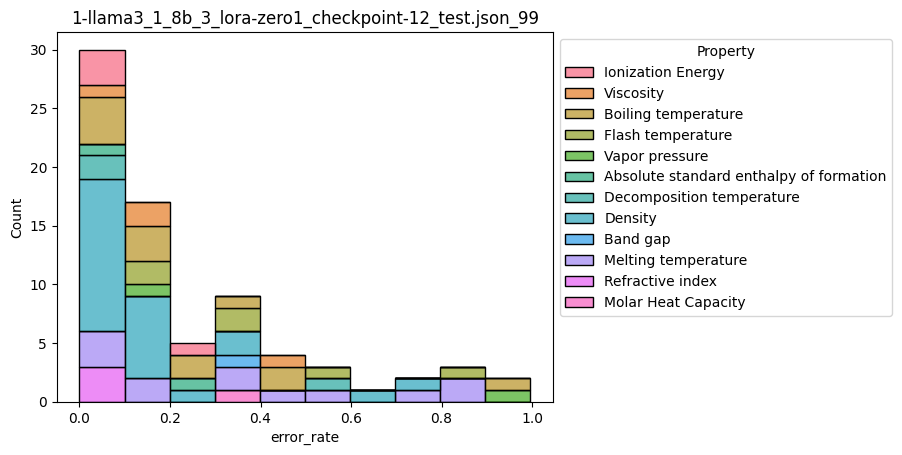

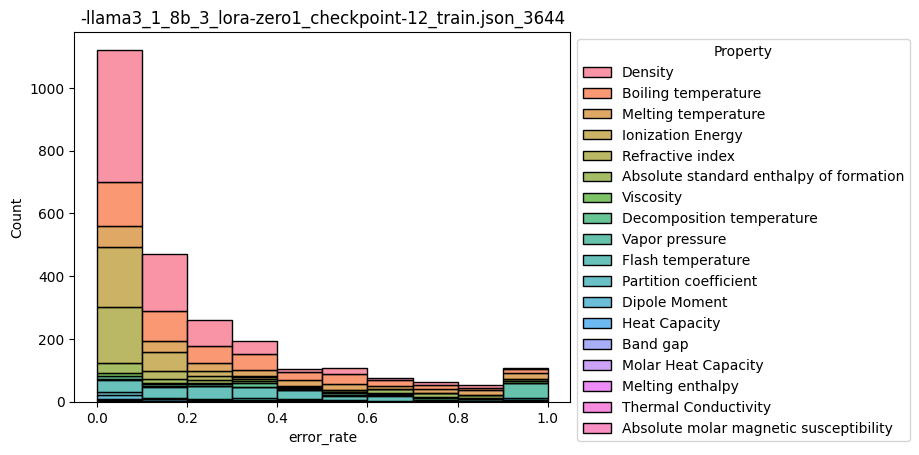

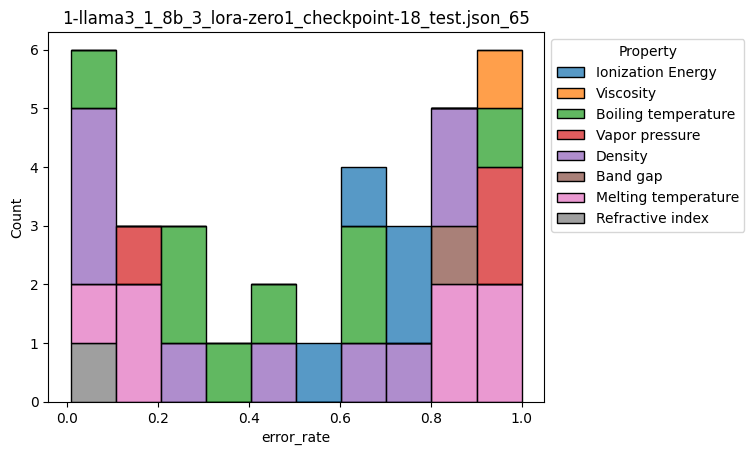

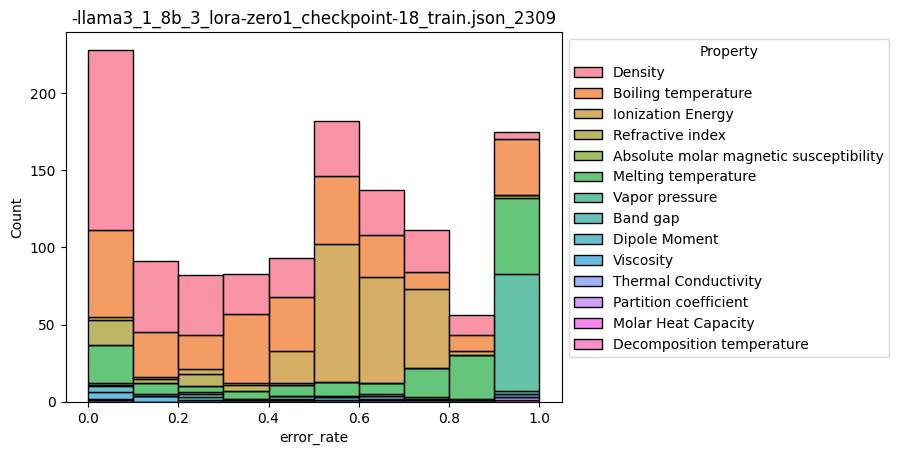

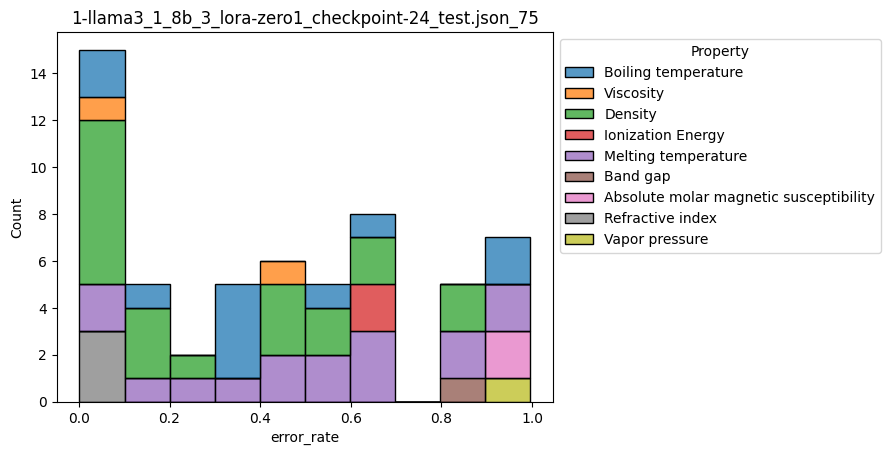

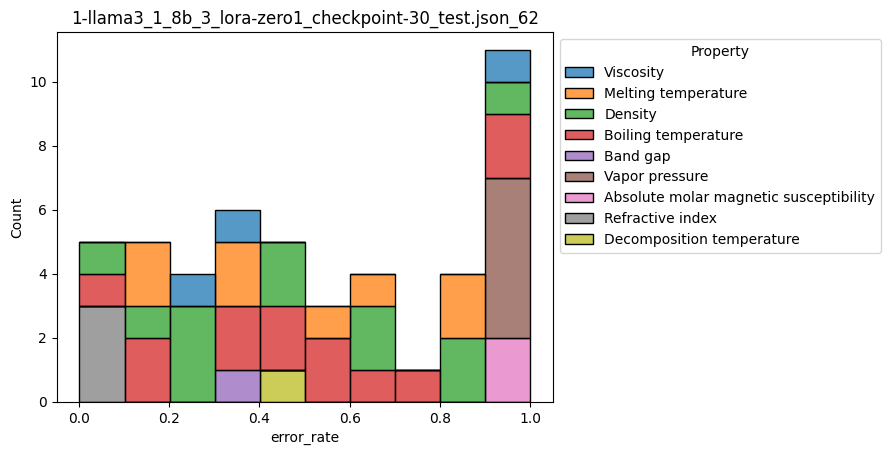

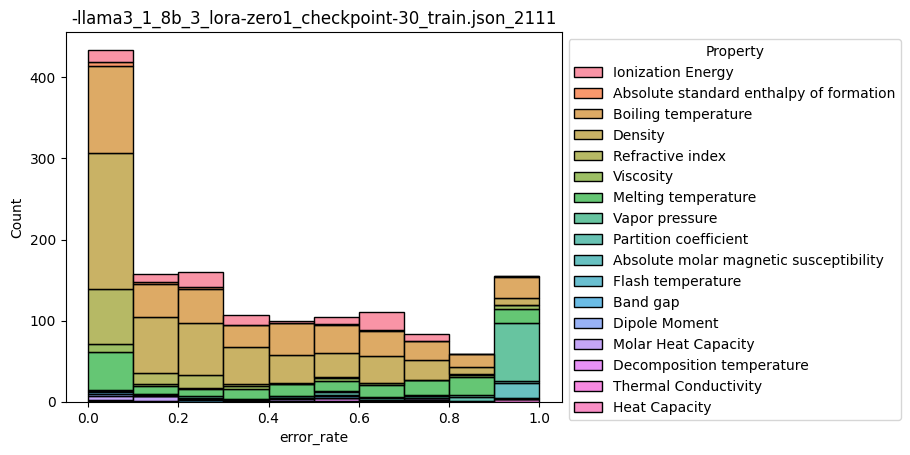

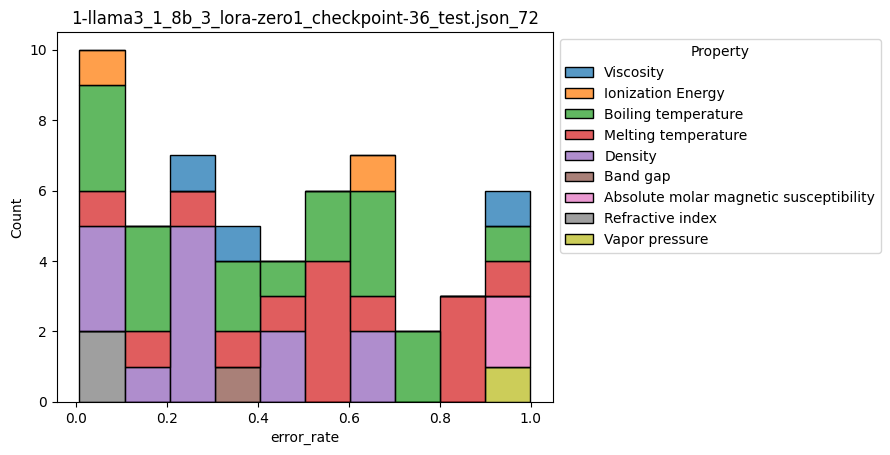

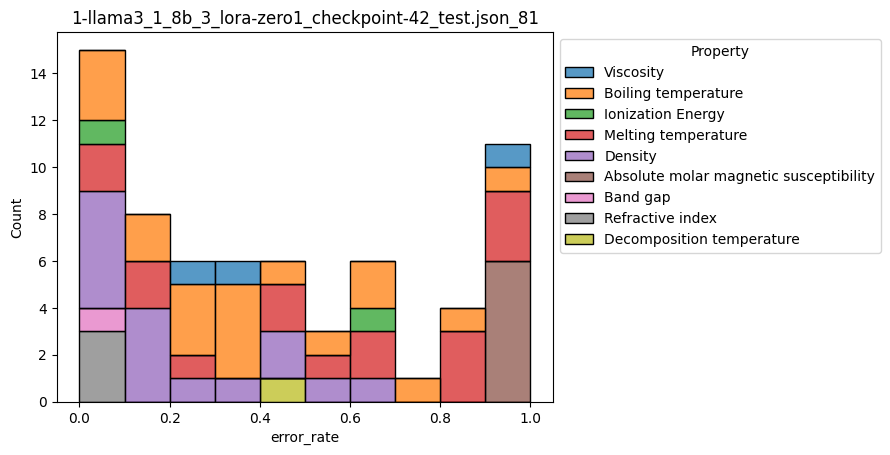

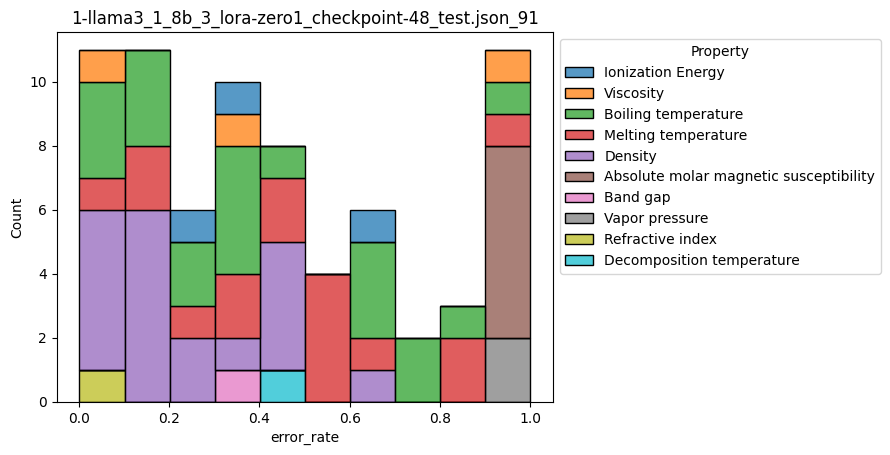

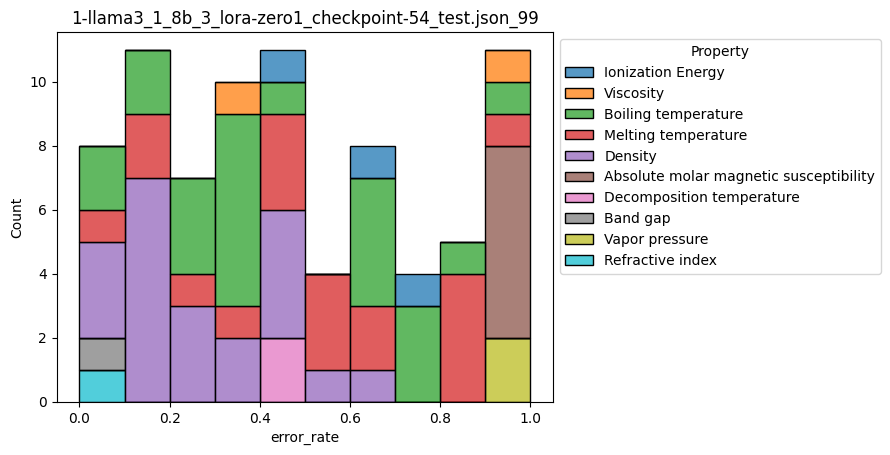

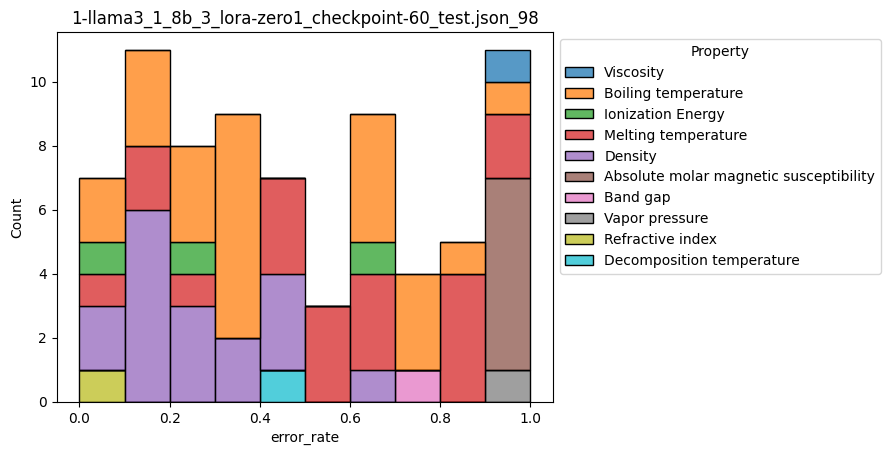

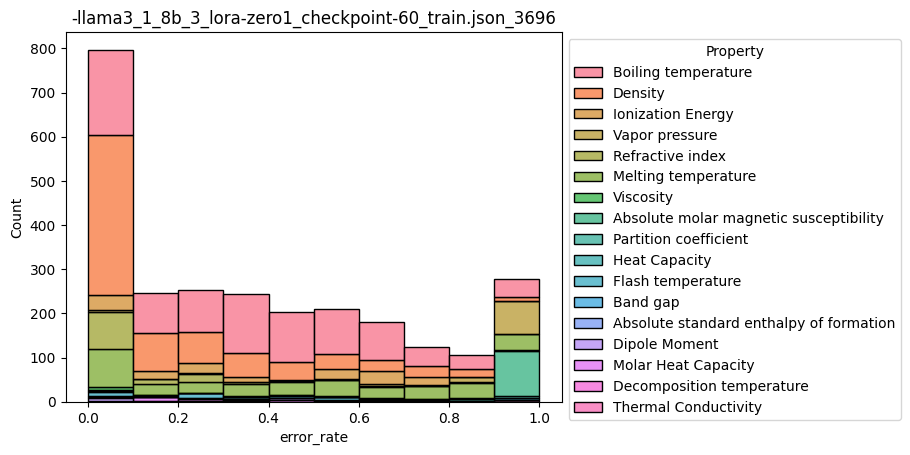

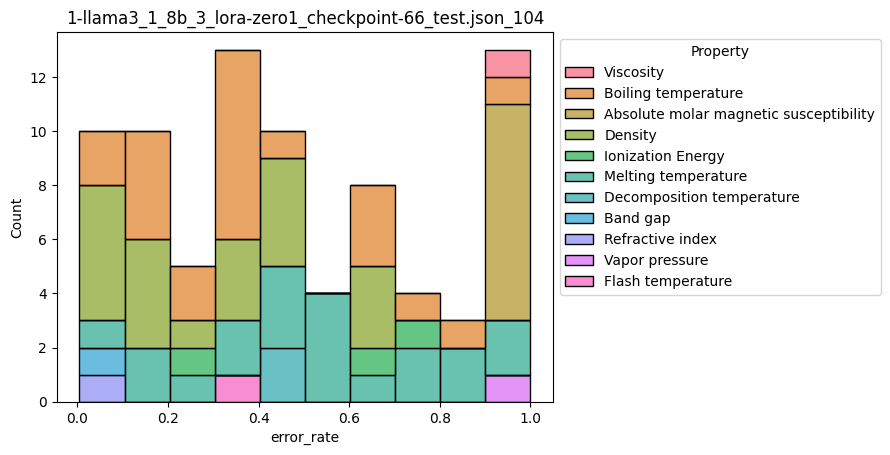

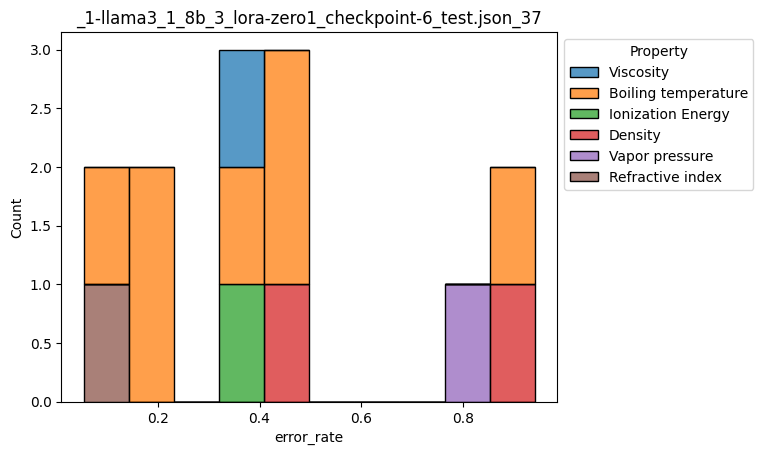

In [141]:
import glob
json_list=[]
#json_list+=glob.glob("eval_results2/*.json")
#json_list+=glob.glob("eval_results_full/*.json")
json_list+=glob.glob("eval_results_lora_llama/*.json")

#json_list+=glob.glob("/data/hatakeyama/self-loop/0920evaluate_prediction_accuracy/eval_results/*.json")

mode="test"

error_rate_dict={}

json_list.sort()

for target_json in json_list:

    #if target_json.find(mode)==-1:
    #    continue

    df=pd.read_json(target_json)
    #predicted_valueをfloatに変更｡変換できないものはNaNにする
    df["predicted_value_float"] = pd.to_numeric(df["predicted_value"], errors='coerce')

    if target_json.find("meta")==-1:
        predicted_text_list=df["predicted_text"].tolist()
        unit_list=df["unit"].tolist()
        predicted_value_list=parse_prediction(predicted_text_list,unit_list)
        df["predicted_value_float"]=predicted_value_list


    #actual_value, predicted_valueの誤差率を計算(絶対値を取る
    df["error_rate"]=(df["Value"]-df["predicted_value_float"])/df["Value"]
    df["error_rate"]=df["error_rate"].abs()

    #誤差率が0以上のものを抽出
    sel_df=df[df["error_rate"]>=0]
    sel_df["predicted_text"].tolist()

    #plt.figure()
    #plt.title(target_json)
    #sns.boxplot(x="error_rate",y="Property",data=sel_df)
    #plt.xlim(-1,2)
    #xはlog
    #plt.xscale("log")
    #x=0.1に縦線を引く
    #plt.axvline(x=0.1, color='r', linestyle='--')

    plt.figure()
    plt.title(target_json[-50:]+"_"+str(sel_df.shape[0]))
    #sns.histplot(data=sel_df,x="error_rate",bins=100,hue="Property")
    ax=sns.histplot(data=sel_df[sel_df["error_rate"]<1],x="error_rate",
                 bins=10,hue="Property",
                multiple="stack"
                 )
    #plt.xlim(0,1)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    error_rate_dict[target_json]=sel_df["error_rate"].median()

In [132]:
error_rate_df=pd.DataFrame(error_rate_dict.items(),columns=["json","median_error_rate"])
error_rate_df["json"].to_list()

['eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-12_test.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-12_train.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-18_test.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-18_train.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-24_test.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-24_train.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-30_test.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-30_train.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_checkpoint-36_test.json',
 'eval_results_full/sftlab_experiments_test_1_output3_1-llama3_1_8b_3-zero1_ch

<Axes: xlabel='step', ylabel='median_error_rate'>

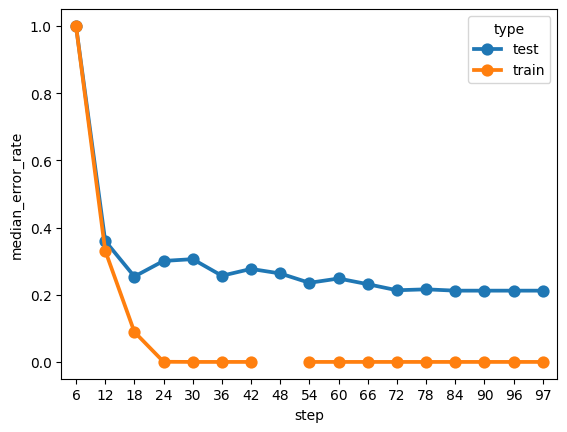

In [133]:
error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["step"] = error_rate_df["step"].fillna(0)
#error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
error_rate_df["type"]=error_rate_df["json"].str.split("_").str[-1].str.split(".").str[0]
sns.pointplot(data=error_rate_df[error_rate_df["json"].str.find("70B")==-1],x="step",y="median_error_rate",hue="type")

In [134]:
#合成された物性データの数
tot_augment_records=1398000*2.5
print("合成された物性データの合計",tot_augment_records)

#元の物性データの数
tot_original_records=7000

#ひとつの物性データがデータベースの中に何回出現するか
total_records_per_property=tot_augment_records/tot_original_records

#今回の学習で使う物性データの数
trained_augment_records=200000
trained_records_per_property=total_records_per_property*trained_augment_records/tot_augment_records
print("今回の学習全体で､特定のpropertyを平均で何回学習するか",trained_records_per_property)

tot_steps=97
seen_times_per_step=trained_records_per_property/tot_steps
print("1stepあたり､特定のpropertyを平均で何回学習するか",seen_times_per_step)

合成された物性データの合計 3495000.0
今回の学習全体で､特定のpropertyを平均で何回学習するか 28.57142857142857
1stepあたり､特定のpropertyを平均で何回学習するか 0.2945508100147275


<Axes: xlabel='Average seen times', ylabel='median_error_rate'>

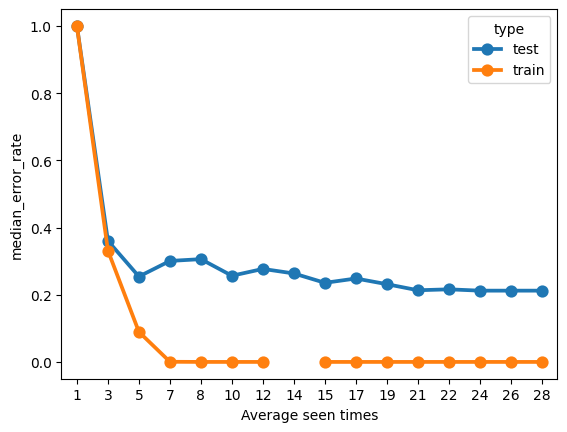

In [135]:

error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["step"] = error_rate_df["step"].fillna(0)
#error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
error_rate_df["type"]=error_rate_df["json"].str.split("_").str[-1].str.split(".").str[0]
error_rate_df["Average seen times"]=(seen_times_per_step*error_rate_df["step"]).astype(int)
sns.pointplot(data=error_rate_df[error_rate_df["json"].str.find("70B")==-1],x="Average seen times",y="median_error_rate",hue="type")

In [136]:
error_rate_df

,json,median_error_rate,temp,step,type,Average seen times
0,eval_results_full/sftlab_experiments_test_1_ou...,0.360317,12_test,12,test,3
1,eval_results_full/sftlab_experiments_test_1_ou...,0.331300,12_train,12,train,3
2,eval_results_full/sftlab_experiments_test_1_ou...,0.254098,18_test,18,test,5
3,eval_results_full/sftlab_experiments_test_1_ou...,0.089388,18_train,18,train,5
4,eval_results_full/sftlab_experiments_test_1_ou...,0.300562,24_test,24,test,7
5,eval_results_full/sftlab_experiments_test_1_ou...,0.000436,24_train,24,train,7
6,eval_results_full/sftlab_experiments_test_1_ou...,0.305882,30_test,30,test,8
7,eval_results_full/sftlab_experiments_test_1_ou...,0.000000,30_train,30,train,8
8,eval_results_full/sftlab_experiments_test_1_ou...,0.256463,36_test,36,test,10
9,eval_results_full/sftlab_experiments_test_1_ou...,0.000000,36_train,36,train,10


<Axes: xlabel='step', ylabel='median_error_rate'>

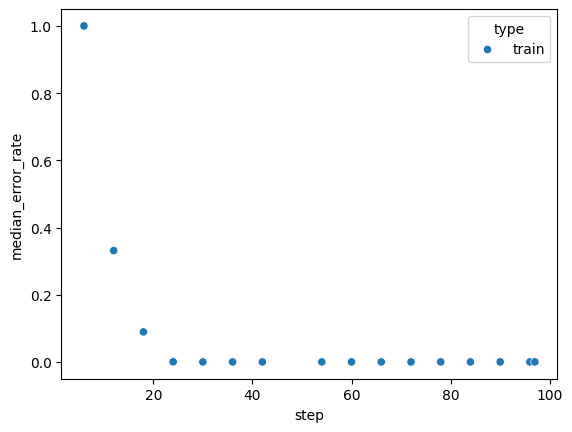

In [137]:

error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
sns.scatterplot(data=error_rate_df[error_rate_df["type"]=="train"],x="step",y="median_error_rate",hue="type")

In [138]:
t="sftlab/experiments/test/1/output3/1-llama3_1_8b_3-zero1/checkpoint-60"
len(t)

69